# The Bern Project: 2D

In [1]:
# Here we just import some of the functions we will use later
import pymc as pm                  #  This is for the Statistics
import matplotlib.pyplot as plt    # This for plotting
import numpy as np                 # This for maths
# This to display the plots in here
%matplotlib inline      

Couldn't import dot_parser, loading of dot files will not be possible.


Defining 1 surface point and 1 underground point with Easting and Elevation coordinate. Model defined as best guess model. This is the part that you would have to do preferibly in GeoModeller if we do it in 3D. For 2D we can try to represent it just with a bunch of points and lines as in this example but for a paper I guess we need to be more professionals I guess (we only need the trial version (wink, wink).

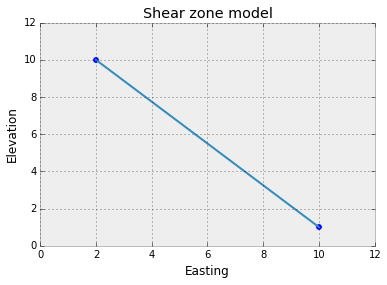

In [2]:
# Surface point coord
a = [2,10]
# tunnel point coord
b = [10,1]

plt.scatter([a[0],b[0]],[a[1],b[1]], s = 40) # Plot the points
plt.plot([a[0],b[0]],[a[1],b[1]])            # Plot the line
plt.xlim(0,12)
plt.ylim(0,12)
plt.title("Shear zone model")
plt.xlabel("Easting")
plt.ylabel("Elevation")
plt.savefig("model.eps")

Now we are going to create the Bayesian Network. Basically we have 4 data.

- The location of the fault on the surface that can be at x = 2 or x = 4.
- The location of the fatul at the tunnel that we keep it constant
- The dip of the Fault

This is representated in the following plot. The ellipses show our uncertain information while the triangles are simply deterministic function (mathematical operations that do not interfere the statistics). The location of the fault in the tunnel is not plotted because we do not give any uncertainty to it (we could if we need):![](Bern.png)

In [3]:
#pm.graph.dag(S).write_png("Bern.png")
#from IPython.core.display import Image
#Image("Bern.png")

In the following cell, we define the shear zone observation points at the surface. These points are here defined as stochastic values, but we can assign a very low uncertainty:

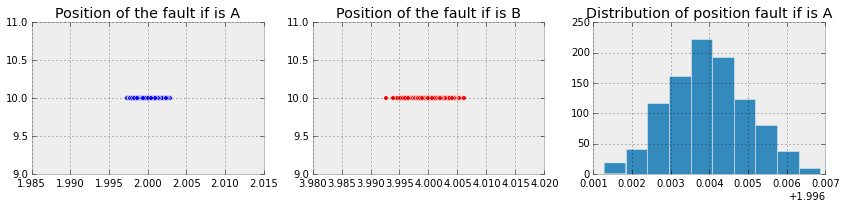

In [4]:
# Point A
x_axis_a = pm.Normal("x_axis_a", 2,1./np.square(2*0.0005)) # This functions generate a normal distribution of o
                                                                    # our position of the surface in x axe,
                                                                    # if you vary this parameters the position of the fault also varies
# Point B
x_axis_b = pm.Normal("x_axis_b", 4,1./np.square(4*0.0005))

# Plotting mean_xaxis_a and b so you can visualize what it is
a = [x_axis_a.random() for i in range(1000)]
b = [x_axis_b.random() for i in range(1000)]
fig, ax = plt.subplots(1, 3, sharex=False, sharey=False, figsize = (12, 3))
ax[0].scatter(a, np.ones_like(a)*10, c = "b")
ax[0].set_ylim(9,11)
ax[0].set_title("Position of the fault if is A")
ax[1].scatter(b, np.ones_like(b)*10, c ="r")
ax[1].set_ylim(9,11)
ax[1].set_title("Position of the fault if is B")
ax[2].hist(a)
ax[2].set_title("Distribution of position fault if is A")
plt.tight_layout()

We have defined where our fault can be (either in A or B). Now, we define a variable that selects between point A and point B with a certain probability

In [5]:
@pm.deterministic
def surface_x_axis( x_axis_a=x_axis_a, x_axis_b = x_axis_b):
    t =  np.random.rand() # This generates a random value between 0 and 1
    if t > 0.5:           # Here we define what is the probability of been in A (otherwise we are in B). In this case we 
                          # have assigned 50%
        return x_axis_a
    else:
        return x_axis_b

Now, we define the position of the shear zone observed in the tunnel with a probability distribution (Normal distribution)

Once our simulation reaches this point we have for every iteration a fault point on the surface (on A or B in the range of our probability distribution) and also our fault point on the tunnel that we have said that is constant. Therefore we can define a geometric dip in 2D. We can do that with deterministic functions (simply mathematical operations of our values).


On the other hand we also incorporate the measured dip as data. When we combine the calculated dip given the uncertainty of the fault point on the surface with the measured dip what we get is constrain our uncertainty. This is the key of all this Bayesian network. Uncertain data from different sources when are integrated in a single statistical model (if the measurement are correct) tend to reduce the global uncertainty

In [6]:
@pm.deterministic
def dip_from_points(surf_x_axis = surface_x_axis):
    x = surf_x_axis # This will be the x value of our surface, either on A or B and whithin our normal distribution
    y = 10          # This is the high of our surface so far constant at 10 but can be also uncertain 
                    #(everything can be uncertain actually)
    
    dip = np.arctan(x/y)    # We calculate the angle (actually this operation is not the dip is the inner angle but whatever)
    dip = np.rad2deg(dip)   # Radians to degrees
    return dip

@pm.stochastic
def dip(value = 30, dip_from_points = dip_from_points):             # Here we define the measured dip
    return pm.normal_like(dip_from_points, 30., 1./np.square(10.))  # We said that our measurement is a normal distribution 
                                                                    # around 30 degrees and standar deviation of 40 
                                                                # (huge uncertainty for the sake of explaination)

# Here we prepare all what we have defined so far to perform the simulation
pymc = pm.Model([surface_x_axis, x_axis_a, x_axis_b, surface_x_axis, dip, dip_from_points]) 
                                                                

In [7]:
# Here we define the type of simulation. This case, MCMC using Adaptive Metropolis
S = pm.MCMC(pymc)

In [8]:
# Perform the Simulation
S.sample(iter = 10000)

 [-----------------100%-----------------] 10000 of 10000 complete in 2.0 sec

So now we can see our posteriors and how the probability distribution of our parameters have changed when we integrate all in a bayesian model. Let's take for example the Dip of the fault.

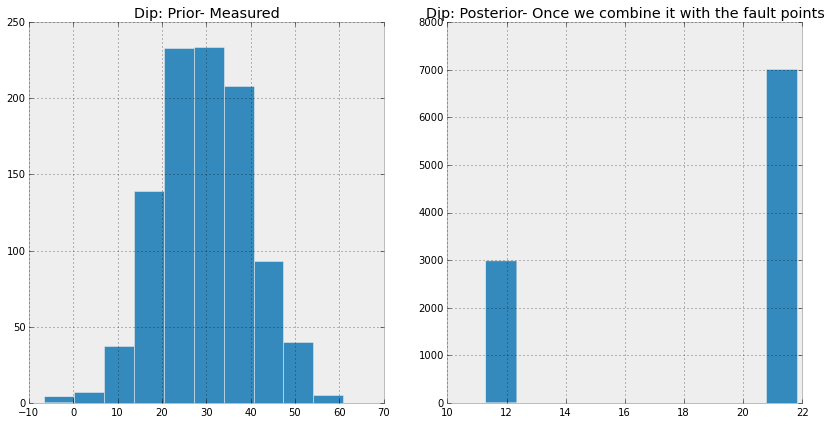

In [10]:
measured_dip = pm.Normal("measured_dip", 30, 1./np.square(10.))
temp = [measured_dip.random() for i in range(1000)]

fig, ax = plt.subplots(1,2, figsize = (12,6))

ax[0].hist(temp)
ax[0].set_title("Dip: Prior- Measured")
ax[1].hist(S.trace("dip_from_points")[:])
ax[1].set_title("Dip: Posterior- Once we combine it with the fault points")
plt.tight_layout()


As you can see the uncertainty of our dip is reduced as crazy since the uncertainty of the fault points are very certain. The only big uncertainty in our model is if we are in A or B (50 %) and that is what is reflected in our posterior (If you make a lot of zoom on the histogram you could see two normal distribution aroun 13 degrees and 24 degrees).

Also notice that because our "measured dip" mean is closer to 22, even if the chance of being at the point A or B are 50 % to honor our "measured dip" our posterior shift to the 22 degrees case.

Here the rest of the posteriors. The trace "dip" I am not sure yet what represent. The real dip posterior is the trace "dip_from_points

Plotting x_axis_b
Plotting dip
Plotting x_axis_a
Plotting dip_from_points
Plotting surface_x_axis


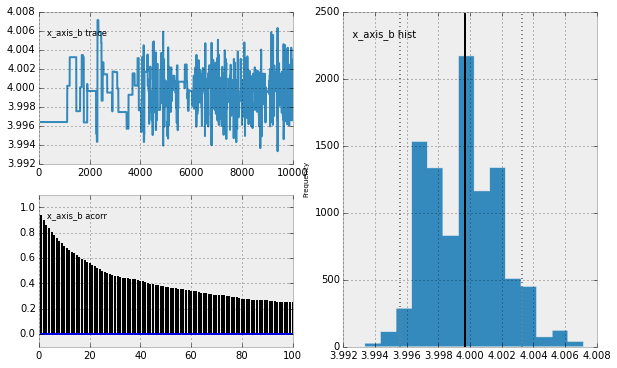

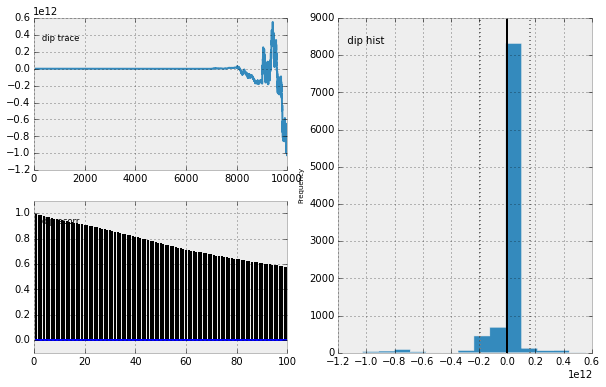

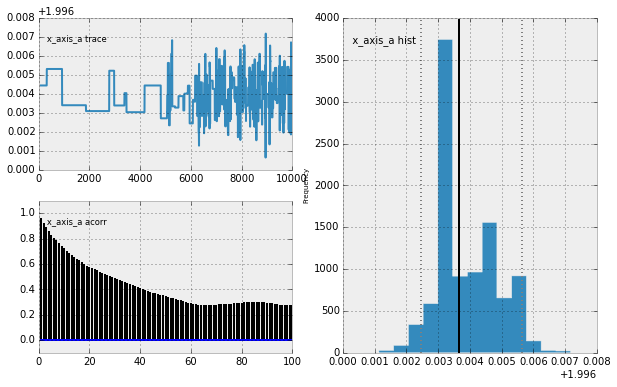

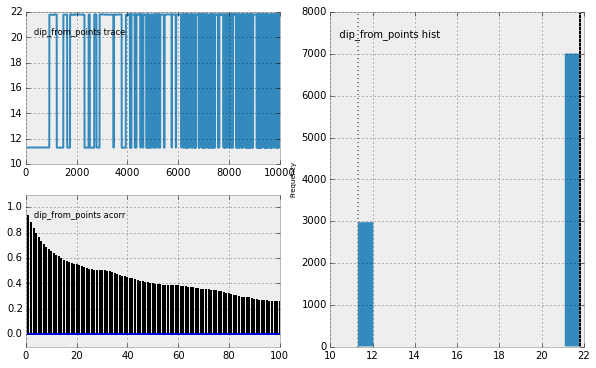

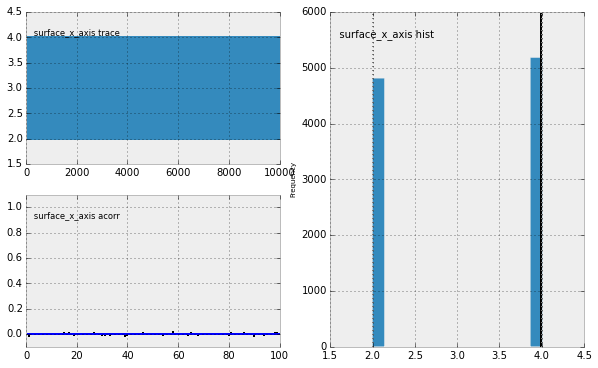

In [11]:
pm.Matplot.plot(S)

Here we have now the representation of our posterior in the 2D plot. Actually if you make zoom close to the A and B cases on the surface you could see that is not a single point but the same distribution that we had above

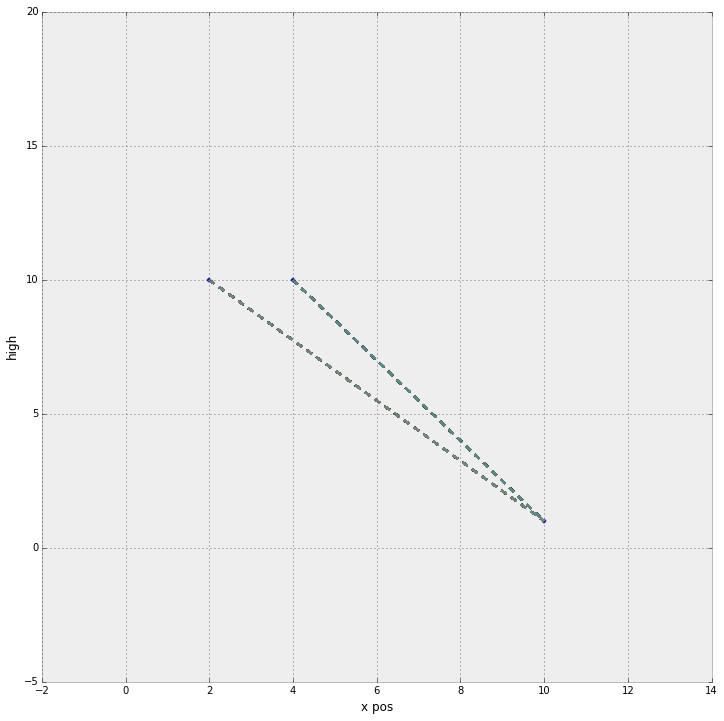

In [12]:
plt.figure(figsize =(12,12))
for i in range(0,4000,5):
    # Surface point coord
    a = [S.trace("surface_x_axis")[i],10]
    # tunnel point coor
    b = [10,1]
    plt.scatter([a[0],b[0]],[a[1],b[1]])
    plt.plot([a[0],b[0]],[a[1],b[1]], "--", alpha = 0.4)
plt.xlim(-2,14)
plt.ylim(-5,20)
plt.xlabel("x pos")
plt.ylabel("high")

(array([ 4815.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,  5185.]),
 array([ 1.99666437,  2.19771292,  2.39876148,  2.59981004,  2.80085859,
         3.00190715,  3.20295571,  3.40400427,  3.60505282,  3.80610138,
         4.00714994]),
 <a list of 10 Patch objects>)

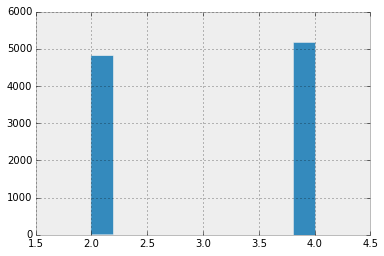

In [13]:
plt.hist(S.trace("surface_x_axis")[:])